In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
uav_path = './Purdue/record/unload/*.wav'
loaded_path = './Purdue/record/load/*.wav'
none_path = './Purdue/record/background/*.wav'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)

In [2]:
CHUNK_SIZE = 8192
SR = 44100
N_MFCC = 16

In [4]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
uav_raw = load(uav_files)
loaded_raw = load(loaded_files)
none_raw = load(none_files)

(62212288,)
(48921530,)
(63941991,)


# Data Processing

In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=44100, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_loaded, y_loaded = mfcc4(loaded_raw, 2)
mfcc_uav, y_uav = mfcc4(uav_raw, 1)
mfcc_none, y_none = mfcc4(none_raw, 0)

print(mfcc_uav.shape, y_uav.shape)
print(mfcc_loaded.shape, y_loaded.shape)
print(mfcc_none.shape, y_none.shape)

(48921530,)
small end: (16, 14)
small end: (16, 6)
(62212288,)
small end: (16, 13)
small end: (16, 5)
(63941991,)
small end: (16, 15)
small end: (16, 7)
(15187, 16, 16) (15187,)
(11942, 16, 16) (11942,)
(15609, 16, 16) (15609,)


In [8]:
X = np.concatenate((mfcc_loaded, mfcc_uav, mfcc_none), axis=0)
y = np.hstack((y_loaded, y_uav, y_none))
print(X.shape, y.shape)

(42738, 16, 16) (42738,)


In [9]:
n_labels = y.shape[0]
n_unique_labels = 3
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(42738, 3)


In [10]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
# validation data
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape, X_test.shape)
print(X_val.shape, y_val.shape)
print(y_train.shape, y_test.shape)

(27352, 16, 16) (8548, 16, 16)
(6838, 16, 16) (6838, 3)
(27352, 3) (8548, 3)


In [13]:
np.save('./X_train_chunk_3d', X_train)
np.save('./X_test_chunk_3d', X_test)
np.save('./X_val_chunk_3d', X_val)
np.save('./y_val_chunk_3d', y_val)
np.save('./y_train_chunk_3d', y_train)
np.save('./y_test_chunk_3d', y_test)

In [3]:
X_train = np.load('./X_train_chunk_3d.npy')
X_test = np.load('./X_test_chunk_3d.npy')
X_val = np.load('./X_val_chunk_3d.npy')
y_val = np.load('./y_val_chunk_3d.npy')
y_train = np.load('./y_train_chunk_3d.npy')
y_test = np.load('./y_test_chunk_3d.npy')

# Experiment 3 - two convolutional layer /w no dropout

##Experiment 3-2
- learning rate 0.005
- pooling stride 1x1
- #filter 1
- best result among every other settings
- cost kept fluctuated during training. (0.8 -> 1.3) -- why is that?

In [4]:
tf.reset_default_graph()

In [6]:
n_mfcc = 16
n_frame = 16
n_classes = 3
n_channels = 1

learning_rate = 0.0002  # 0.005
training_epochs = 2000

# Layer 1 

In [7]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)

conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, 16*16*1])

In [8]:
dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Y_pred = tf.contrib.layers.fully_connected(logits,n_classes,activation_fn = None)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val2 = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

In [11]:
model_path = './cnnmodel'
saver = tf.train.Saver()

In [12]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools as it

In [13]:
###########################
batch_size = 256
cost_history = np.empty(shape=[1], dtype=float)

for epoch in range(training_epochs):#training epoch 500 / batch_size 128 --> acc 90%
    avg_cost = 0
    val_avg_cost =0
    total_batch = int(y_train.shape[0] / batch_size)
    for i in range(0, y_train.shape[0], batch_size):
        feed_dict={X:X_train2[i:i+batch_size,:,:,:], Y:y_train[i:i+batch_size,:]}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        cost_history = np.append(cost_history,cost)
        avg_cost += c/total_batch 
    
    y_pred = sess.run(logits, feed_dict={X:X_val2})
    y_pred = sess.run(tf.argmax(y_pred,1))
    y_true = y_val
        
    y_true = sess.run(tf.argmax(y_true,1))
    print(len(y_pred),end=' ')
    print('Epoch:', '%04d' % (epoch+1), 'cost = ', '{:.9f}'.format(avg_cost), 'val = ','%f' %(accuracy_score(y_true, y_pred)) )
saver.save(sess, model_path)

6838 Epoch: 0001 cost =  1.033808268 val =  0.747587
6838 Epoch: 0002 cost =  0.615841273 val =  0.785317
6838 Epoch: 0003 cost =  0.559577410 val =  0.797163
6838 Epoch: 0004 cost =  0.527919437 val =  0.803598
6838 Epoch: 0005 cost =  0.506111726 val =  0.811495
6838 Epoch: 0006 cost =  0.484398110 val =  0.815882
6838 Epoch: 0007 cost =  0.468218655 val =  0.817929
6838 Epoch: 0008 cost =  0.455185908 val =  0.820415
6838 Epoch: 0009 cost =  0.444007130 val =  0.825534
6838 Epoch: 0010 cost =  0.434327061 val =  0.824510
6838 Epoch: 0011 cost =  0.424177784 val =  0.825826
6838 Epoch: 0012 cost =  0.415807806 val =  0.829336
6838 Epoch: 0013 cost =  0.407394956 val =  0.830214
6838 Epoch: 0014 cost =  0.400780434 val =  0.834455
6838 Epoch: 0015 cost =  0.395276737 val =  0.834601
6838 Epoch: 0016 cost =  0.388290214 val =  0.837672
6838 Epoch: 0017 cost =  0.382946675 val =  0.835917
6838 Epoch: 0018 cost =  0.378597250 val =  0.838403
6838 Epoch: 0019 cost =  0.372932005 val =  0.

6838 Epoch: 0156 cost =  0.174664261 val =  0.850395
6838 Epoch: 0157 cost =  0.174012695 val =  0.850249
6838 Epoch: 0158 cost =  0.172631934 val =  0.852735
6838 Epoch: 0159 cost =  0.172119458 val =  0.852150
6838 Epoch: 0160 cost =  0.171751552 val =  0.849079
6838 Epoch: 0161 cost =  0.171532993 val =  0.849079
6838 Epoch: 0162 cost =  0.170710878 val =  0.848201
6838 Epoch: 0163 cost =  0.170284845 val =  0.847616
6838 Epoch: 0164 cost =  0.169985562 val =  0.849079
6838 Epoch: 0165 cost =  0.169571314 val =  0.847324
6838 Epoch: 0166 cost =  0.168995717 val =  0.847616
6838 Epoch: 0167 cost =  0.169421241 val =  0.845423
6838 Epoch: 0168 cost =  0.171873683 val =  0.860924
6838 Epoch: 0169 cost =  0.185097569 val =  0.841767
6838 Epoch: 0170 cost =  0.173147928 val =  0.853173
6838 Epoch: 0171 cost =  0.173076555 val =  0.857561
6838 Epoch: 0172 cost =  0.173620578 val =  0.863264
6838 Epoch: 0173 cost =  0.172238789 val =  0.868675
6838 Epoch: 0174 cost =  0.173750895 val =  0.

6838 Epoch: 0311 cost =  0.094959958 val =  0.876280
6838 Epoch: 0312 cost =  0.094764201 val =  0.876280
6838 Epoch: 0313 cost =  0.093453629 val =  0.877011
6838 Epoch: 0314 cost =  0.092957026 val =  0.877596
6838 Epoch: 0315 cost =  0.091713306 val =  0.877011
6838 Epoch: 0316 cost =  0.091389623 val =  0.877596
6838 Epoch: 0317 cost =  0.090963816 val =  0.876426
6838 Epoch: 0318 cost =  0.090365209 val =  0.877303
6838 Epoch: 0319 cost =  0.089868474 val =  0.877157
6838 Epoch: 0320 cost =  0.089068807 val =  0.877011
6838 Epoch: 0321 cost =  0.088444546 val =  0.877157
6838 Epoch: 0322 cost =  0.087868976 val =  0.876426
6838 Epoch: 0323 cost =  0.087758478 val =  0.876280
6838 Epoch: 0324 cost =  0.087079604 val =  0.876280
6838 Epoch: 0325 cost =  0.086861997 val =  0.877888
6838 Epoch: 0326 cost =  0.086318090 val =  0.876280
6838 Epoch: 0327 cost =  0.086072581 val =  0.877450
6838 Epoch: 0328 cost =  0.085396349 val =  0.877011
6838 Epoch: 0329 cost =  0.085151915 val =  0.

6838 Epoch: 0466 cost =  0.057073840 val =  0.878035
6838 Epoch: 0467 cost =  0.055366751 val =  0.880082
6838 Epoch: 0468 cost =  0.055188057 val =  0.878912
6838 Epoch: 0469 cost =  0.054174029 val =  0.880228
6838 Epoch: 0470 cost =  0.053927525 val =  0.879789
6838 Epoch: 0471 cost =  0.053538779 val =  0.879936
6838 Epoch: 0472 cost =  0.053128838 val =  0.880667
6838 Epoch: 0473 cost =  0.051854707 val =  0.880228
6838 Epoch: 0474 cost =  0.051915913 val =  0.879204
6838 Epoch: 0475 cost =  0.051268523 val =  0.879351
6838 Epoch: 0476 cost =  0.050963820 val =  0.878766
6838 Epoch: 0477 cost =  0.050571065 val =  0.878035
6838 Epoch: 0478 cost =  0.049821565 val =  0.878327
6838 Epoch: 0479 cost =  0.049987767 val =  0.879789
6838 Epoch: 0480 cost =  0.048740247 val =  0.877303
6838 Epoch: 0481 cost =  0.048504506 val =  0.878181
6838 Epoch: 0482 cost =  0.047942828 val =  0.877157
6838 Epoch: 0483 cost =  0.047715382 val =  0.877596
6838 Epoch: 0484 cost =  0.047121283 val =  0.

6838 Epoch: 0621 cost =  0.034170925 val =  0.871892
6838 Epoch: 0622 cost =  0.035769099 val =  0.872916
6838 Epoch: 0623 cost =  0.037165644 val =  0.873501
6838 Epoch: 0624 cost =  0.038593234 val =  0.872916
6838 Epoch: 0625 cost =  0.039445450 val =  0.871161
6838 Epoch: 0626 cost =  0.038013525 val =  0.871746
6838 Epoch: 0627 cost =  0.040674744 val =  0.868821
6838 Epoch: 0628 cost =  0.042726770 val =  0.872185
6838 Epoch: 0629 cost =  0.040635494 val =  0.874378
6838 Epoch: 0630 cost =  0.042914359 val =  0.873062
6838 Epoch: 0631 cost =  0.043829911 val =  0.872185
6838 Epoch: 0632 cost =  0.041372247 val =  0.873794
6838 Epoch: 0633 cost =  0.041998980 val =  0.867651
6838 Epoch: 0634 cost =  0.043139163 val =  0.869699
6838 Epoch: 0635 cost =  0.042675485 val =  0.869699
6838 Epoch: 0636 cost =  0.042037734 val =  0.872331
6838 Epoch: 0637 cost =  0.043469841 val =  0.869406
6838 Epoch: 0638 cost =  0.043146529 val =  0.865750
6838 Epoch: 0639 cost =  0.039289018 val =  0.

6838 Epoch: 0776 cost =  0.011237429 val =  0.870576
6838 Epoch: 0777 cost =  0.011185480 val =  0.869991
6838 Epoch: 0778 cost =  0.011367945 val =  0.869991
6838 Epoch: 0779 cost =  0.010996789 val =  0.869845
6838 Epoch: 0780 cost =  0.011309251 val =  0.870722
6838 Epoch: 0781 cost =  0.011902585 val =  0.869260
6838 Epoch: 0782 cost =  0.085291282 val =  0.865604
6838 Epoch: 0783 cost =  0.054564948 val =  0.868236
6838 Epoch: 0784 cost =  0.019825970 val =  0.872185
6838 Epoch: 0785 cost =  0.014854415 val =  0.870869
6838 Epoch: 0786 cost =  0.013972051 val =  0.871892
6838 Epoch: 0787 cost =  0.013510723 val =  0.872477
6838 Epoch: 0788 cost =  0.013320963 val =  0.873209
6838 Epoch: 0789 cost =  0.012914413 val =  0.873209
6838 Epoch: 0790 cost =  0.012955597 val =  0.872477
6838 Epoch: 0791 cost =  0.012954097 val =  0.872039
6838 Epoch: 0792 cost =  0.012921585 val =  0.871746
6838 Epoch: 0793 cost =  0.012965846 val =  0.872624
6838 Epoch: 0794 cost =  0.012902857 val =  0.

6838 Epoch: 0931 cost =  0.011469057 val =  0.868821
6838 Epoch: 0932 cost =  0.011015570 val =  0.868675
6838 Epoch: 0933 cost =  0.011369359 val =  0.866774
6838 Epoch: 0934 cost =  0.011442413 val =  0.870137
6838 Epoch: 0935 cost =  0.012231215 val =  0.868090
6838 Epoch: 0936 cost =  0.012676426 val =  0.870284
6838 Epoch: 0937 cost =  0.013134389 val =  0.868090
6838 Epoch: 0938 cost =  0.013106027 val =  0.867651
6838 Epoch: 0939 cost =  0.014295545 val =  0.865604
6838 Epoch: 0940 cost =  0.014766903 val =  0.864580
6838 Epoch: 0941 cost =  0.032585951 val =  0.864434
6838 Epoch: 0942 cost =  0.021025068 val =  0.859169
6838 Epoch: 0943 cost =  0.015109917 val =  0.868090
6838 Epoch: 0944 cost =  0.012598438 val =  0.871600
6838 Epoch: 0945 cost =  0.013435963 val =  0.868090
6838 Epoch: 0946 cost =  0.016388497 val =  0.865750
6838 Epoch: 0947 cost =  0.015670570 val =  0.866920
6838 Epoch: 0948 cost =  0.016989797 val =  0.865458
6838 Epoch: 0949 cost =  0.021591718 val =  0.

6838 Epoch: 1086 cost =  0.002561299 val =  0.868236
6838 Epoch: 1087 cost =  0.002498653 val =  0.868090
6838 Epoch: 1088 cost =  0.002472383 val =  0.867798
6838 Epoch: 1089 cost =  0.002461320 val =  0.868236
6838 Epoch: 1090 cost =  0.002459152 val =  0.868090
6838 Epoch: 1091 cost =  0.002424833 val =  0.867944
6838 Epoch: 1092 cost =  0.002372300 val =  0.867651
6838 Epoch: 1093 cost =  0.002456236 val =  0.868968
6838 Epoch: 1094 cost =  0.002459323 val =  0.867798
6838 Epoch: 1095 cost =  0.002472032 val =  0.868968
6838 Epoch: 1096 cost =  0.002264766 val =  0.868529
6838 Epoch: 1097 cost =  0.002351653 val =  0.867359
6838 Epoch: 1098 cost =  0.002360080 val =  0.868090
6838 Epoch: 1099 cost =  0.002231102 val =  0.868529
6838 Epoch: 1100 cost =  0.002290818 val =  0.868675
6838 Epoch: 1101 cost =  0.002188737 val =  0.867944
6838 Epoch: 1102 cost =  0.002294448 val =  0.867213
6838 Epoch: 1103 cost =  0.002195041 val =  0.868383
6838 Epoch: 1104 cost =  0.002158479 val =  0.

6838 Epoch: 1241 cost =  0.001986388 val =  0.866335
6838 Epoch: 1242 cost =  0.001971604 val =  0.865165
6838 Epoch: 1243 cost =  0.002049039 val =  0.865165
6838 Epoch: 1244 cost =  0.002099244 val =  0.865458
6838 Epoch: 1245 cost =  0.001948310 val =  0.867066
6838 Epoch: 1246 cost =  0.002006285 val =  0.865896
6838 Epoch: 1247 cost =  0.001834156 val =  0.865165
6838 Epoch: 1248 cost =  0.030633655 val =  0.835917
6838 Epoch: 1249 cost =  0.122272304 val =  0.863557
6838 Epoch: 1250 cost =  0.017405496 val =  0.865896
6838 Epoch: 1251 cost =  0.008069795 val =  0.868675
6838 Epoch: 1252 cost =  0.004236209 val =  0.865458
6838 Epoch: 1253 cost =  0.003876177 val =  0.864873
6838 Epoch: 1254 cost =  0.003806524 val =  0.865311
6838 Epoch: 1255 cost =  0.003640115 val =  0.865165
6838 Epoch: 1256 cost =  0.003403368 val =  0.864434
6838 Epoch: 1257 cost =  0.003340802 val =  0.865458
6838 Epoch: 1258 cost =  0.003174829 val =  0.864873
6838 Epoch: 1259 cost =  0.003103500 val =  0.

6838 Epoch: 1396 cost =  0.001265202 val =  0.868236
6838 Epoch: 1397 cost =  0.001258484 val =  0.868529
6838 Epoch: 1398 cost =  0.001268143 val =  0.869114
6838 Epoch: 1399 cost =  0.001217820 val =  0.869114
6838 Epoch: 1400 cost =  0.001237793 val =  0.868821
6838 Epoch: 1401 cost =  0.001246426 val =  0.868968
6838 Epoch: 1402 cost =  0.001216793 val =  0.869553
6838 Epoch: 1403 cost =  0.001222218 val =  0.869406
6838 Epoch: 1404 cost =  0.001230992 val =  0.869699
6838 Epoch: 1405 cost =  0.001214298 val =  0.869406
6838 Epoch: 1406 cost =  0.001212683 val =  0.868968
6838 Epoch: 1407 cost =  0.001222391 val =  0.869114
6838 Epoch: 1408 cost =  0.001211819 val =  0.869845
6838 Epoch: 1409 cost =  0.001211830 val =  0.869553
6838 Epoch: 1410 cost =  0.001215364 val =  0.869699
6838 Epoch: 1411 cost =  0.001214202 val =  0.869845
6838 Epoch: 1412 cost =  0.001206304 val =  0.868821
6838 Epoch: 1413 cost =  0.001226253 val =  0.869991
6838 Epoch: 1414 cost =  0.001211874 val =  0.

6838 Epoch: 1551 cost =  0.000857966 val =  0.869260
6838 Epoch: 1552 cost =  0.000866367 val =  0.869406
6838 Epoch: 1553 cost =  0.000872534 val =  0.869406
6838 Epoch: 1554 cost =  0.000882965 val =  0.870137
6838 Epoch: 1555 cost =  0.000895041 val =  0.869553
6838 Epoch: 1556 cost =  0.000899128 val =  0.869553
6838 Epoch: 1557 cost =  0.000927519 val =  0.869260
6838 Epoch: 1558 cost =  0.000910005 val =  0.869991
6838 Epoch: 1559 cost =  0.000934601 val =  0.869553
6838 Epoch: 1560 cost =  0.000961495 val =  0.869845
6838 Epoch: 1561 cost =  0.000963847 val =  0.869991
6838 Epoch: 1562 cost =  0.000988520 val =  0.869114
6838 Epoch: 1563 cost =  0.000987743 val =  0.869699
6838 Epoch: 1564 cost =  0.001010097 val =  0.869260
6838 Epoch: 1565 cost =  0.001010561 val =  0.869406
6838 Epoch: 1566 cost =  0.001023970 val =  0.869114
6838 Epoch: 1567 cost =  0.001024440 val =  0.869553
6838 Epoch: 1568 cost =  0.001028123 val =  0.868675
6838 Epoch: 1569 cost =  0.001030300 val =  0.

6838 Epoch: 1706 cost =  0.001019914 val =  0.867505
6838 Epoch: 1707 cost =  0.001017942 val =  0.867066
6838 Epoch: 1708 cost =  0.001015612 val =  0.867213
6838 Epoch: 1709 cost =  0.001013528 val =  0.867359
6838 Epoch: 1710 cost =  0.001045418 val =  0.867798
6838 Epoch: 1711 cost =  0.001070707 val =  0.867213
6838 Epoch: 1712 cost =  0.001113107 val =  0.867505
6838 Epoch: 1713 cost =  0.095622713 val =  0.864580
6838 Epoch: 1714 cost =  0.022732758 val =  0.866628
6838 Epoch: 1715 cost =  0.005858349 val =  0.867651
6838 Epoch: 1716 cost =  0.001744150 val =  0.866774
6838 Epoch: 1717 cost =  0.001102155 val =  0.867505
6838 Epoch: 1718 cost =  0.000958926 val =  0.868529
6838 Epoch: 1719 cost =  0.000910427 val =  0.868236
6838 Epoch: 1720 cost =  0.000899025 val =  0.868090
6838 Epoch: 1721 cost =  0.000892982 val =  0.868529
6838 Epoch: 1722 cost =  0.000887173 val =  0.868675
6838 Epoch: 1723 cost =  0.000899295 val =  0.868968
6838 Epoch: 1724 cost =  0.000896573 val =  0.

6838 Epoch: 1861 cost =  0.000626857 val =  0.870430
6838 Epoch: 1862 cost =  0.000633825 val =  0.870722
6838 Epoch: 1863 cost =  0.000641432 val =  0.871015
6838 Epoch: 1864 cost =  0.000669631 val =  0.870576
6838 Epoch: 1865 cost =  0.000666128 val =  0.870430
6838 Epoch: 1866 cost =  0.000668708 val =  0.870430
6838 Epoch: 1867 cost =  0.000679109 val =  0.870284
6838 Epoch: 1868 cost =  0.000689409 val =  0.870284
6838 Epoch: 1869 cost =  0.000699707 val =  0.870430
6838 Epoch: 1870 cost =  0.000710926 val =  0.870430
6838 Epoch: 1871 cost =  0.000719561 val =  0.870430
6838 Epoch: 1872 cost =  0.000730064 val =  0.870284
6838 Epoch: 1873 cost =  0.000738107 val =  0.870576
6838 Epoch: 1874 cost =  0.000747607 val =  0.870576
6838 Epoch: 1875 cost =  0.000756270 val =  0.870576
6838 Epoch: 1876 cost =  0.000771860 val =  0.871161
6838 Epoch: 1877 cost =  0.000763116 val =  0.870284
6838 Epoch: 1878 cost =  0.000757536 val =  0.870284
6838 Epoch: 1879 cost =  0.000769294 val =  0.

'./cnnmodel'

In [14]:
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test2})
y_true = sess.run(tf.argmax(y_test,1))

F-Score: 0.872
Accuracy:  0.871548900327562
             precision    recall  f1-score   support

          0       0.91      0.92      0.92      3141
          1       0.86      0.86      0.86      2975
          2       0.83      0.82      0.83      2432

avg / total       0.87      0.87      0.87      8548

[[2903  120  118]
 [ 143 2549  283]
 [ 127  307 1998]]


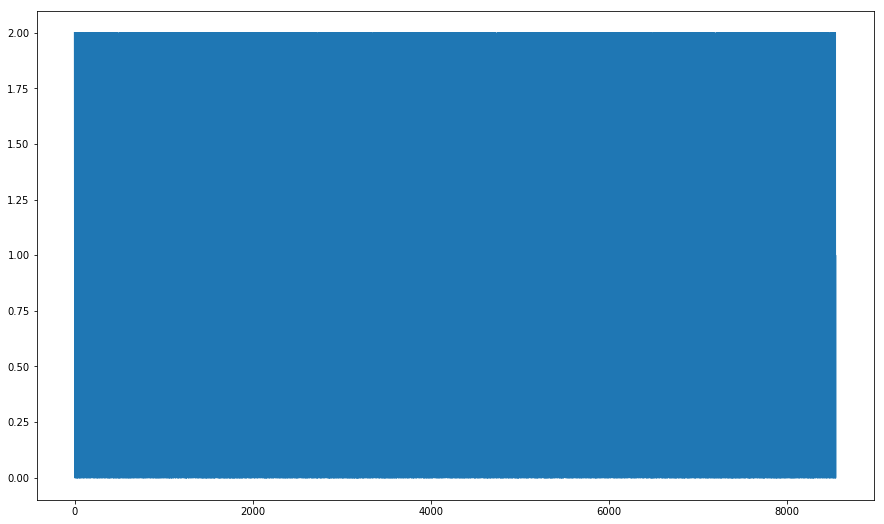

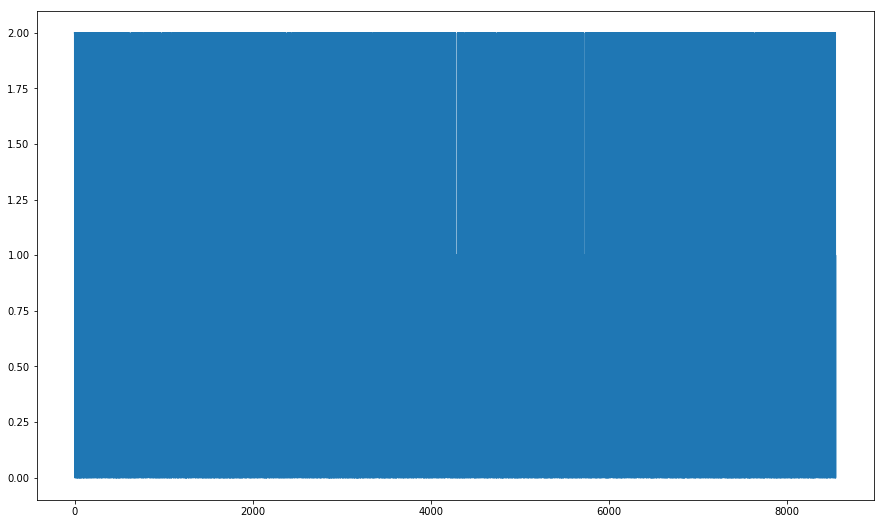

In [15]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

### print true graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true)

### print pred graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

In [26]:
'''learning rate 0.01
batch size 64
epoch 100
-> 78%'''
'''learning rate 0.01
batch size 128
epoch 100
-> 77%'''
'''learning rate 0.0002
batch size 64
epoch 100
-> 85%'''
'''learning rate 0.0002
batch size 64
epoch 50
-> 85%'''
'''learning rate 0.0002
batch size 32
epoch 100
-> 90%'''
#########################
'''
batch size 32
epoch 100
83%
'''
'''
batch size 64
epoch 100
83%
'''
'''
batch size 128
epoch 1000
83%
'''
# 현재 90%

'\nbatch size 64\nepoch 100\n83%\n'